# Orientation representation development

Figure 2 of the 2022 bioRxiv paper contains a variety of orientation representation plots that could serve as validation for our understanding of the dataset.

To generate the orientation representation plots, there are two instructions: J.Neurosci. and bioRxiv. The instructions were a bit difficult to decipher, but there are two methods:
- J.Neurosci. - Construct 1000 resampled trials matrices and average them together.
- - Each resampled trial is constructed by randomly selecting 250 neurons, randomly selecting a trial for each neuron, sort neurons by their preferred orientation, sum neurons with the same orientation, and insert them into a trial matrix. Baseline subtract the trial matrix and smooth across orientation space.
- bioRxiv - For each neuron, average spike traces across neurons and subtract the mean. Average activity across neurons, sort by preferred orientation, and construct activity matrix.

In this notebook, we will use the J.Neurosci. method as it is probably the method used in the bioRxiv paper.

### Note!
The methods for `baseline subtraction` are not clear from either papers. But upon looking at Corbo's code, one must subtract the baseline from individual neurons and use the mean activity from the first 23 frames (the frames before stimulus presentation) to subtract the baseline.

## Imports

In [1]:
%cd ../../
%load_ext autoreload
%autoreload 2

/home/jovyan/work/task-priors


In [2]:
import os
from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.ndimage import gaussian_filter1d

from src.data_access import (
load_tables, 
retrieve_experiment_ids, 
retrieve_recording_day_experiment_ids, 
construct_testing_trial_bank, 
retrieve_admissible_neurons, 
sample_trial_and_retrieve_trace_FAST
)

from src.orientation_representation import (
enforce_spike_trace_length,
load_all_experiments_into_memory,
generate_resampled_trial_matrix,
plot_orientation_representation,
)

In [3]:
rng = np.random.default_rng(12345)

In [4]:
tables = load_tables()
df_celltable, df_trialtable = tables
experiment_ids = retrieve_experiment_ids(tables)

/home/jovyan/work/task-priors/src/data_access.py:21: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_celltable = pd.read_csv(DATASET['CellTable_path'])


## Construct orientation representation objects
To make an orientation representation plot, we need to select a particular recording day and visual stimulus. We use these to construct:
- a list of experiment IDs recorded during the recording day
- a dictionary of trials (referred to as "trial bank")
- a dataframe of neurons in associated with the list of experiment IDs (referred to as "admissible neurons")

In [5]:
recording_day = 'D2'
visual_stimulus = 45

In [6]:
relevant_experiment_ids = retrieve_recording_day_experiment_ids(recording_day, tables)
trial_bank = construct_testing_trial_bank(relevant_experiment_ids, recording_day, visual_stimulus, tables)
admissible_neurons = retrieve_admissible_neurons(relevant_experiment_ids, tables)

In [7]:
# As a quick check, given that there are 10 mice, we should expect 10 experiment IDs
len (relevant_experiment_ids) == 10

True

## Resample trial matrix generation
Now that we've generate our orientation representation objects, we need to generate a resampled trial matrix.
- First: Initialize a 0-matrix, termed `trial_matrix`, of size `(360, trial_length)`.
  - `360` is the number of preferred neuron orientations
  - `trial_length` is the length of spike traces
- Second: Sample, without replacement, 250 neurons from `admissible_neurons`.
- Third: Sample, without replacement, a trial from each admissible neuron and return the associated spike trace.
  - We'll use the `sample_trial_and_retrieve_trace_FAST` function
- Fourth: Enforce each spike trace to be `trial_length` via padding or indexing.
  - We'll use the `enforce_spike_trace_length` function
- Fifth: Insert the spike trace into the `trial_matrix` via the corresponding orientation.
- Sixth: Subtract the baseline, mean, of the `trial_matrix`.
- Seventh: Smooth across the preferred orientation axis via a Gaussian filter with a standard deviation of 6 degrees.

In [8]:
# First
trial_length = 105
trial_matrix = np.zeros((360, trial_length,))

In [9]:
# Second, ensure that a random seed is provided
sampled_neurons = admissible_neurons.sample(250, random_state=42, replace=False)

In [10]:
# Third
for row in tqdm(sampled_neurons.itertuples()):
    spike_trace = sample_trial_and_retrieve_trace_FAST(rng, row, trial_bank)

    # Fourth
    spike_trace = enforce_spike_trace_length(spike_trace, trial_length)

    # Fifth
    pref_orientation = int(row.Pref_Orientation_spikes_2)
    orientation_index = pref_orientation - 1 # I will forget about this and be sorry
    trial_matrix[orientation_index, :] += spike_trace # Notice how this is a summation

250it [00:31,  7.98it/s]


Note that while the `sample_trial_and_retrieve_trace_FAST` function uses the word "FAST" in its naming, the function has to index HDF5 files and is inherently slow.

In [11]:
# Sixth
trial_matrix = trial_matrix - np.mean(trial_matrix)

In [12]:
# Seventh, take note of the `sigma=6`
trial_matrix = gaussian_filter1d(trial_matrix, sigma=6, axis=0, mode='wrap')

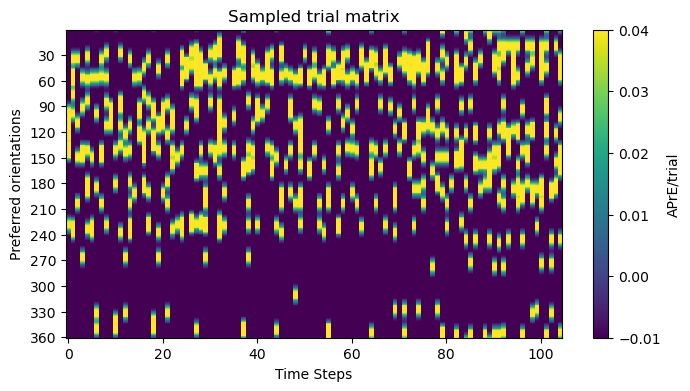

In [13]:
# Let's see what it looks like
plot_orientation_representation(trial_matrix, 'Sampled trial matrix')

### `generate_resampled_trial_matrix`
Now that we have our generated resampled trial process solidified, we can functionalize it.

Note that the `generate_resampled_trial_matrix` is different from the procedure defined above. The steps are the same, but it loads all trial data from HDF5 files into the `experiment_data` variable first, before querying it. The result is a significantly faster `trial_matrix` generation.

In [14]:
experiment_data = load_all_experiments_into_memory(trial_bank)

100%|█████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 161.52it/s]


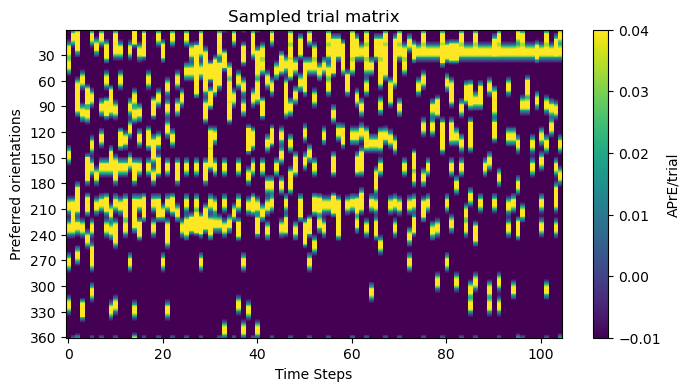

In [15]:
trial_matrix = generate_resampled_trial_matrix(
    admissible_neurons, 
    trial_bank, 
    trial_length, 
    experiment_data, 
    69, 
    tqdm_disable=False
)
plot_orientation_representation(trial_matrix, 'Sampled trial matrix')

In [16]:
# Let's make sure it's reproducible
trial_matrix_1 = generate_resampled_trial_matrix(
    admissible_neurons, 
    trial_bank, 
    trial_length, 
    experiment_data, 
    69, 
    tqdm_disable=False
)
np.array_equal(trial_matrix, trial_matrix_1)

100%|█████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 422.50it/s]


True

## Resampling 1000 trials
Do not use this code since the `np.random.randint` function is not seeded. 

In [17]:
def construct_orientation_representation(rng_seed, admissible_neurons, trial_bank, trial_length, experiment_data, num_trials=1000):
    
    rng = np.random.default_rng(rng_seed) # Very important to use the rng_seed
    random_seeds = rng.integers(low=0, high=2**32, size=num_trials)

    results = []
    for random_seed in tqdm(random_seeds):
        trial_matrix = generate_resampled_trial_matrix(
            admissible_neurons, 
            trial_bank, 
            trial_length, 
            experiment_data, 
            random_seed, 
        )
        results.append(trial_matrix)
        
    return np.mean(np.array(results), axis=0)

In [18]:
rng_seed = 69
orientation_matrix = construct_orientation_representation(
    rng_seed, 
    admissible_neurons, 
    trial_bank, 
    trial_length, 
    experiment_data,
)

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.40it/s]


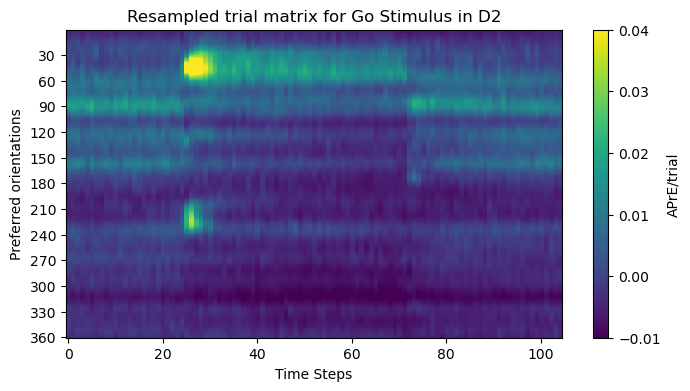

In [19]:
plot_orientation_representation(orientation_matrix, 'Resampled trial matrix for Go Stimulus in D2',)

Okay that's cool. The figure looks quite similar to figure 2.a from the bioRxiv paper, except for the activation at 90 degrees.

In [20]:
# Let's make sure that the `construct_orientation_representation` function is reproducible
orientation_matrix_1 = construct_orientation_representation(
    rng_seed, 
    admissible_neurons, 
    trial_bank, 
    trial_length, 
    experiment_data,
)
np.array_equal(orientation_matrix, orientation_matrix_1)

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.36it/s]


True

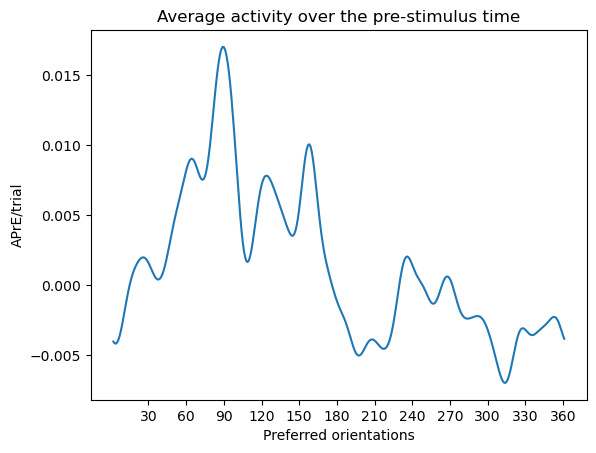

In [21]:
plt.plot(np.arange(1,361,), np.mean(orientation_matrix[:, :20], axis=-1))
x_ticks = np.arange(29, 360, 30)
plt.xticks(x_ticks, x_ticks + 1)
plt.title('Average activity over the pre-stimulus time')
plt.xlabel('Preferred orientations')
plt.ylabel('APrE/trial')
plt.show()

## bioRxiv method
Given the artifact at 90 degrees in the figure above, we should also explore the method described in the bioRxiv paper.

In [22]:
trial_length = 105
trial_matrix = np.zeros((360, trial_length,))
count_array = np.zeros(360)

In [23]:
for row in tqdm(admissible_neurons.itertuples()):
    experiment_id = row.Experiment
    cell_index = row.Cell - 1
    cell_spike_trace = np.zeros(trial_length)
    orientation_index = int(row.Pref_Orientation_spikes_2) - 1

    for trial_id in experiment_data[experiment_id]:
        spike_trace = experiment_data[experiment_id][trial_id][:,cell_index]
        cell_spike_trace += enforce_spike_trace_length(spike_trace, trial_length)

    cell_spike_trace = cell_spike_trace / len(experiment_data[experiment_id].keys())

    trial_matrix[orientation_index, :] += cell_spike_trace
    count_array[orientation_index] += 1

2524it [00:01, 1601.50it/s]


In [24]:
safe_count_array = np.where(count_array == 0, 1, count_array)
trial_matrix = trial_matrix / safe_count_array[:, np.newaxis]

In [25]:
trial_matrix = trial_matrix - np.mean(trial_matrix)
trial_matrix = gaussian_filter1d(trial_matrix, sigma=6, axis=0, mode='wrap')

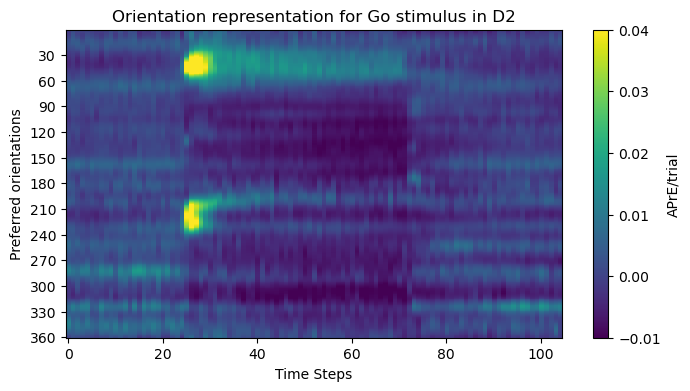

In [26]:
plot_orientation_representation(trial_matrix, 'Orientation representation for Go stimulus in D2', save_fig='./results/orientation_representations/go_stim_D2.png')

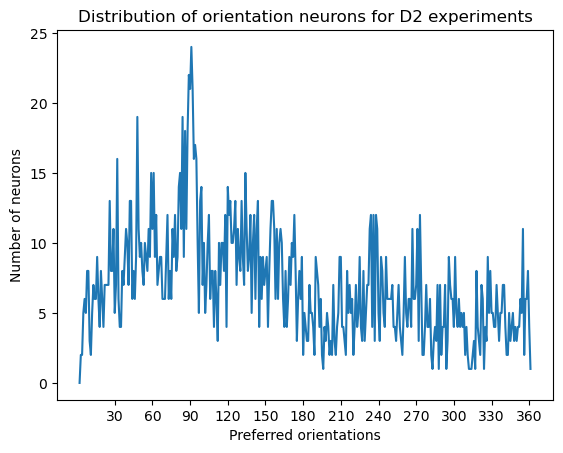

In [27]:
plt.plot(np.arange(1,361,), count_array,)
x_ticks = np.arange(29, 360, 30)
plt.xticks(x_ticks, x_ticks + 1)
plt.title('Distribution of orientation neurons for D2 experiments')
plt.xlabel('Preferred orientations')
plt.ylabel('Number of neurons')
plt.show()

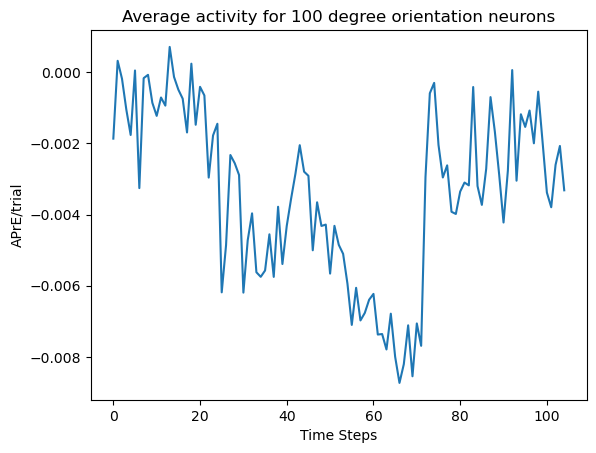

In [28]:
plt.plot(trial_matrix[101,:],)
plt.title('Average activity for 100 degree orientation neurons')
plt.xlabel('Time Steps')
plt.ylabel('APrE/trial')
plt.show()

Okay, the bioRxiv approach makes a lot of sense and more closely reproduces the figures in the paper. Let's functionalize it.

In [29]:
from src.orientation_representation import construct_orientation_representation

trial_matrix_1 = construct_orientation_representation(admissible_neurons, experiment_data, trial_length, tqdm_disable=False)
np.array_equal(trial_matrix, trial_matrix_1)

2524it [00:01, 1692.21it/s]


True